In [104]:
# core python
import dask
import numpy as np
import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

In [2]:
from pyMKL import mkl_set_num_threads
# use a single thread 
# num_threads = 1
# mkl_set_num_threads(num_threads)

## model parameters

In [3]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 
# csz=1.25

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [4]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [5]:
model = casingSim.model.CasingInHalfspace(
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [6]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [7]:
print(model.diffusion_distance(1))


12615.6626101008


In [8]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

### create "approximate" models
- treat the well as a solid cylinder
- use a conductivity equal to that product of the conductivity and cross-sectional area of the casing
- to approximate the permeability, I preserve the product of the permeability and the thickness of the casing wall

In [9]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

model_solid_steel = model_approx_casing.copy()
model_solid_steel.sigma_inside = model.sigma_casing
model_solid_steel.sigma_casing = model.sigma_casing
model_solid_steel.filename = "solid_steel.json"

The approximate conductivity of the solid we use is 1.8e+06


keep track of the models in a dictionary

In [10]:
model_names = ["casing", "approx_casing", "solid_steel"] 
models = [model, model_approx_casing, model_solid_steel]
model_dict = dict(zip(
    model_names, 
    models 
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [11]:
model.diffusion_distance()

5701.1071274119095

In [12]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [13]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
#     npadx = 10, 
#     npadz = 19,
    csz = csz,
)
# meshGen.save()

In [14]:
mesh = meshGen.mesh

In [15]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


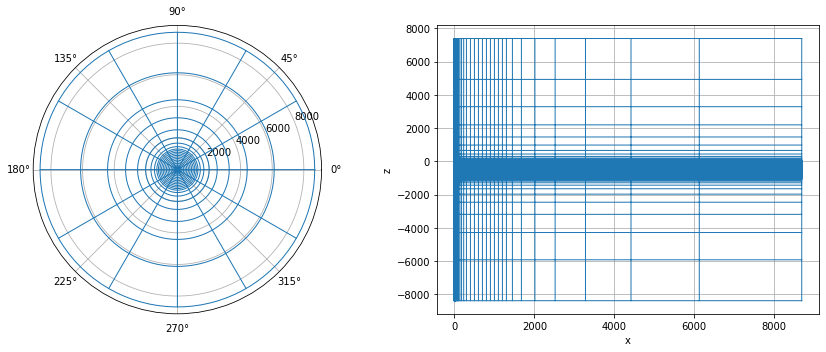

In [16]:
ax = mesh.plotGrid()

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [17]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


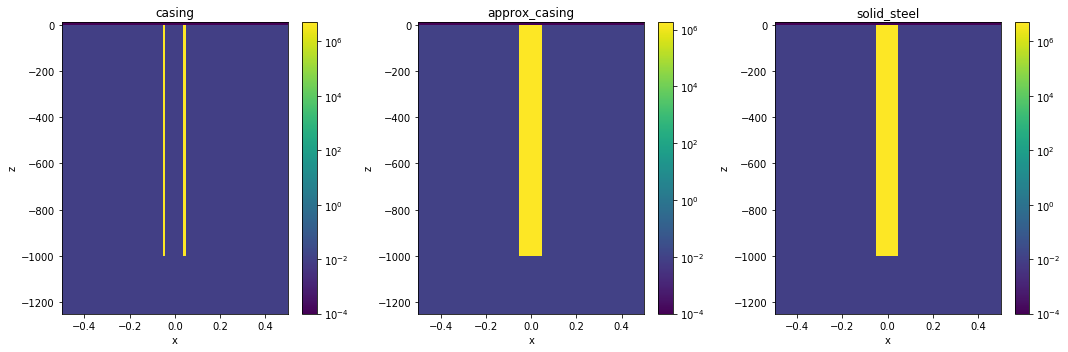

In [18]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

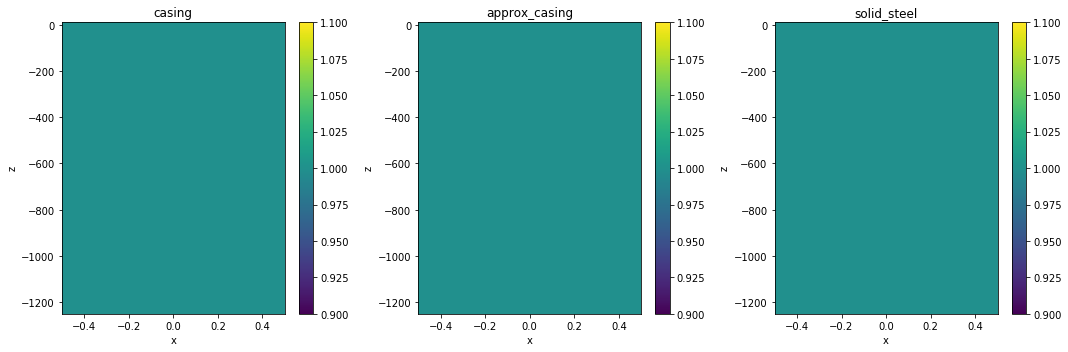

In [19]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [20]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [21]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [22]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [23]:
src_top = casingSim.sources.TopCasingSrc(
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [24]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    sources = sources  
)

source_list = casingSimSrcList.srcList

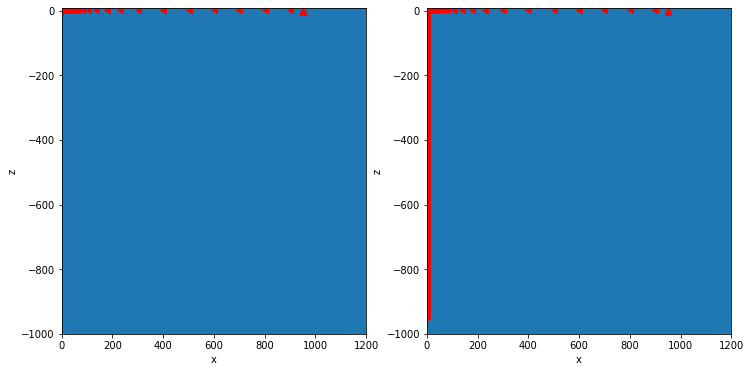

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [26]:
run = False
use_cluster = True
# run = True
# use_cluster = True

In [27]:
survey = tdem.Survey(source_list)

In [28]:
formulation = "j"

if formulation == "h":
    sim = tdem.Problem3D_h(
        mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
        time_steps=timeSteps
    )
elif formulation == "j":
    sim = tdem.Problem3D_j(
        mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
        time_steps=timeSteps
    )

In [29]:
import dask
import dask_jobqueue
from dask.distributed import Client
from dask.diagnostics import ProgressBar

In [30]:
# dask_jobqueue.SLURMCluster??

In [31]:
if use_cluster is True: 
    cluster = dask_jobqueue.SLURMCluster(
        cores=len(model_names),
        processes=len(model_names), memory='120GB', 
        job_cpu=5*len(model_names),
        project="m3384",
        job_extra = ['--constraint=haswell', '--qos=debug',], 
        death_timeout=360,
    )

    print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=15
#SBATCH --mem=112G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug
JOB_ID=${SLURM_JOB_ID%;*}



/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.44:46769 --nthreads 1 --nprocs 3 --memory-limit 40.00GB --name dask-worker--${JOB_ID}-- --death-timeout 360



In [32]:
# Client?

In [33]:
if use_cluster is True: 
    client = Client(cluster)
else: 
    client = Client(threads_per_worker=1, n_workers=1)
client

Client Scheduler: tcp://128.55.224.44:46769 Dashboard: http://128.55.224.44:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [34]:
# @dask.delayed
def run_simulation(m, simulation_params, directory=None, name=None):
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from pymatsolver import Pardiso
        
    if isinstance(simulation_params, str):
        simulation_params = json.loads(simulation_params)
    
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    
    if isinstance(m, str):
        model = casing_sim.model.CasingInHalfspace.deserialize(json.loads(m), trusted=True)
        m = model.sigma(sim.mesh)
    
    sim.solver = Pardiso
    sim.verbose = True
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
    if name is not None: 
        filename = f"{name}.npy"
        tosave = os.path.sep.join([directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    return tosave

In [35]:
if use_cluster is True:
    cluster.adapt()
#     cluster.scale(3)
    print("cluster scaled")
    cluster

cluster scaled


In [36]:
if run is True: 
    f = {}
    for key, value in physprops_dict.items():
        time = datetime.datetime.now()
        model = model_dict[key]
        directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"

        if not os.path.isdir(directory):
            os.makedirs(directory, exist_ok=True)

        model.save(f"{key}.json", directory)
        sigma = dask.delayed(value.sigma)
        f[key] = dask.delayed(run_simulation)(
            value.sigma, sim.serialize(), directory, key
        )
    
    

In [37]:
if run is True: 
    fields_files = dask.compute(f)[0]
else:
    fields_files = {}
#     directory = "20198821/1000m_sigma1e-02/"
    directory = '20198413/1000m_sigma1e-02/'
    for key in model_names:
        fields_files[key] = f"{directory}{key}.npy"

load the results into memory and re-populate the fields object (this takes a couple minutes). 

In [38]:
fields_files

{'casing': '20198413/1000m_sigma1e-02/casing.npy',
 'approx_casing': '20198413/1000m_sigma1e-02/approx_casing.npy',
 'solid_steel': '20198413/1000m_sigma1e-02/solid_steel.npy'}

In [39]:
solution_dict = {}
for key, val in fields_files.items():
    solution_dict[key] = np.load(val)

In [40]:
m = model_dict['casing']

In [41]:
cluster.close()

#### todo: profile this at some point - the fields object should not be this expensive to create

In [42]:
solution_dict["approx_casing"].shape

(1279680, 2, 188)

In [43]:
fields_dict = {}

for key in model_names:
    print(key)
    sim.model = model_dict[key].sigma(sim.mesh)
    fields_dict[key] = sim.fieldsPair(sim)
    fields_dict[key][:, f'{formulation}Solution', :] = solution_dict.pop(key)

casing


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


approx_casing
solid_steel


In [44]:
# sim_dict = {}
# for key in model_names:
#     sim_dict[key] = sim.copy()
#     sim_dict[key].modelParameters = model_dict[key]
#     sim_dict[key].srcList = sim.srcList

# mesh = sim_dict["casing"].meshGenerator.mesh

In [45]:
viewer = casingSim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict={key: sim.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [46]:
# viewer = casingSim.FieldsViewer(
#     model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
# )

In [47]:
out1 = viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)
out1

/global/u2/l/lheagy/git/simpeg/simpeg/SimPEG/survey.py:369: UserWarning: srcList has been renamed to source_list. Please update your code accordingly
  "srcList has been renamed to source_list. Please update your code "


interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [48]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [49]:
viewer.primary = "casing"

In [50]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [51]:
# # compute a source term from the charge 

# def get_s_e(src, tind, key="approx_casing", primary_key="casing"):
#     charge = fields_dict[key][src, 'charge', tind] - fields_dict[primary_key][src, 'charge', tind]
    
#     # solve the DC problem

In [52]:
# def dc_src_term(src, tind, key="approx_casing", primary_key="casing"):
#     j_diff =  fields_dict[key][src, 'j', tind] - fields_dict[primary_key][src, 'j', tind]
#     return - mesh.faceDiv * j_diff

In [53]:
def theta_index_mirror(theta_ind):
    return (
        theta_ind+int(mesh.vnC[1]/2)
        if theta_ind < int(mesh.vnC[1]/2)
        else theta_ind-int(mesh.vnC[1]/2)
    )

In [54]:
# # plot the divergence of js 

# def plot_div_jdiff(
#     src, tind, theta_ind=0, model_key="approx_casing", primary_key="casing", ax=None, xlim=None, zlim=None, clim=None
# ):
    
#     if ax is None:
#         fig, ax = plt.subplots(1, 1)
           
#     plotme = dc_src_term(src, tind, model_key, primary_key)
    
#     theta_ind_mirror = theta_index_mirror(theta_ind)
    
#     if clim is None:
#         clim = np.r_[-1., 1.] * np.max(np.absolute(plotme))
        
#     plotme = plotme.reshape(mesh.vnC, order='F')
#     mirror_data = discretize.utils.mkvc(
#         plotme[:, theta_ind_mirror, :]
#     )
#     plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])
#     mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
#     out = mesh2D.plotImage(
#         plotme, ax=ax,
#         pcolorOpts = {'cmap': 'RdBu_r'},
#         clim=clim,
#         mirror_data=mirror_data,
#         mirror=True
#     )
#     ax.set_xlim(xlim)
#     ax.set_ylim(zlim)
#     plt.colorbar(out[0], ax=ax)


interactive(children=(IntSlider(value=0, description='tind', max=188), IntSlider(value=3, description='theta_i…

<function __main__.widget_div_j(tind, theta_ind, clim)>

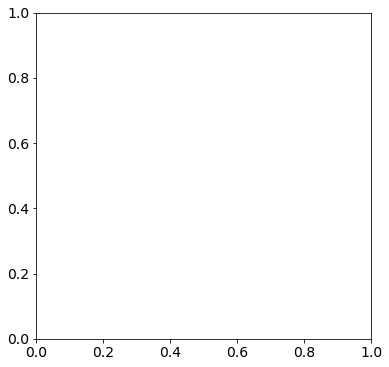

In [55]:
def widget_div_j(tind, theta_ind, clim):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_div_jdiff(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=clim*np.r_[-1,1]
    ),

ipywidgets.interact(
    widget_div_j, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim = ipywidgets.FloatText(value=1.5e-2)
)

In [56]:
def compute_sm_error(src, tind=None, key="approx_casing", primary_key="casing", separate=False):
    if tind is None: 
        tind = slice(0, sim.nT)
    j_diff =  fields_dict[key][src, 'j', tind] - fields_dict[primary_key][src, 'j', tind]
    dhdt_diff = fields_dict[key][src, 'dhdt', tind] - fields_dict[primary_key][src, 'dhdt', tind]
    
    C = mesh.edgeCurl
    MfRho = mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh))
    MeMu = mesh.getEdgeInnerProduct(model_dict[key].mur(mesh)*mu_0)
    
    if separate is True:
        return (C.T * MfRho * j_diff, MeMu * dhdt_diff)
    return C.T * MfRho * j_diff + MeMu * dhdt_diff

In [57]:
def compute_se_error(src, tind=None, key="approx_casing", primary_key="casing", separate=False):
    if tind is None: 
        tind = slice(0, sim.nT)
        
    e = fields_dict[key][src, 'e', tind]
    e_diff =  fields_dict[key][src, 'e', tind] - fields_dict[primary_key][src, 'e', tind]
    
    MfRhoeI = (
        mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh), invMat=True) - 
        mesh.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh), invMat=True)
    )
    
    if separate is True:
        return (MfRhoeI*e, MfRhoeI*e_diff)
    return MfRhoeI*(e + e_diff)

In [58]:
def plot_sm_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = compute_sm_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_sm_error(src, tind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh.aveE2CC * plotme
    else:
        plotme = (mesh.aveE2CCV * plotme)[mesh.nC:2*mesh.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

#     mirror_data = casingSim.ccv3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
#     plotme = casingSim.ccv3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    
#     plotme = discretize.utils.mkvc(np.hstack([plotme[:mesh.nCx*mesh.nCz], plotme[(mesh.nCx*mesh.nCz)*2:]]))
#     mirror_data = discretize.utils.mkvc(np.hstack([mirror_data[:mesh.nCx*mesh.nCz], mirror_data[(mesh.nCx*mesh.nCz)*2:]]))
        
#     plot_type = "vec"
#     norm = LogNorm()
    
    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm, 'cmap': 'BrBG'}, clim=clim,
        mirror_data=mirror_data, mirror=True, 
#         view="vec", vType="CCv",
#         sample_grid = np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
#         range_x=xlim, range_y=zlim
    )
    
#     mesh.plotGrid(ax=ax, linewidth=0.1, color='k', slice="theta")

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    


In [59]:
from matplotlib.colors import LogNorm, SymLogNorm

In [60]:
def widget_sm(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_sm_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_sm, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-6),
    clim_max = ipywidgets.FloatText(value=1e-4),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

interactive(children=(IntSlider(value=0, description='tind', max=188), IntSlider(value=3, description='theta_i…

<function __main__.widget_sm(tind, theta_ind, clim_min, clim_max, term)>

In [61]:
def prim_sec_source(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", separate=False):
    C = mesh.edgeCurl
    MfRhoe = mesh.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh) - 1./model_dict[key].sigma(mesh))
    j = fields_dict[key][src, 'j', tind]
    je = fields_dict[primary_key][src, 'j', tind] - j
    source = (
        - C.T * MfRhoe * j, -C.T * MfRhoe * je
    )
    
    if separate:
        return source
    else:
        return(sum(source))
    
    

In [62]:
def plot_prim_sec_src(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = prim_sec_source(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = prim_sec_source(src, tind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh.aveE2CC * plotme
    else:
        plotme = (mesh.aveE2CCV * plotme)[mesh.nC:2*mesh.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm}, clim=clim,
        mirror_data=mirror_data, mirror=True, grid=True
    )
    

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    mesh2D.plotGrid(ax=ax)
    


In [63]:
def widget_prim_sec_src(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_sm_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_prim_sec_src, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-6),
    clim_max = ipywidgets.FloatText(value=1e-4),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

interactive(children=(IntSlider(value=0, description='tind', max=188), IntSlider(value=3, description='theta_i…

<function __main__.widget_prim_sec_src(tind, theta_ind, clim_min, clim_max, term)>

In [64]:
def plot_se_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    eps = 1e-10
    if term in [0, 1]:
        plotme = compute_se_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_se_error(src, tind, key, primary_key)

    theta_ind_mirror = theta_index_mirror(theta_ind)
    plt_vec = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    mirror_data = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
    plot_type = "vec"
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = casingSim.view.plotFace2D(
        mesh2D, plt_vec, ax=ax, range_x=xlim, range_y=zlim,
        sample_grid=(
            np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]
#             if xlim is not None and zlim is not None else None
        ),
        log_scale=True,
        clim=clim,
        stream_threshold=clim[0] if clim is not None else None,
        mirror=True,
        mirror_data=mirror_data,
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_title(f"electric source term \n t={sim.times[tind]:1.1e}s")
    


In [65]:
def widget_se(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_se_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_se, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1),
    clim_max = ipywidgets.FloatText(value=1e8),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

interactive(children=(IntSlider(value=0, description='tind', max=188), IntSlider(value=3, description='theta_i…

<function __main__.widget_se(tind, theta_ind, clim_min, clim_max, term)>

In [66]:
sm = compute_sm_error(survey.srcList[0], tind = 0, key="approx_casing", primary_key="casing", separate=False)

In [67]:
smx = sm[:mesh.vnE[0]]
smy = sm[mesh.vnE[0]:mesh.vnE[:2].sum()]
smz = sm[mesh.vnE[:2].sum():]

In [68]:
smz.shape, mesh.nEz

((426684, 1), 426684)

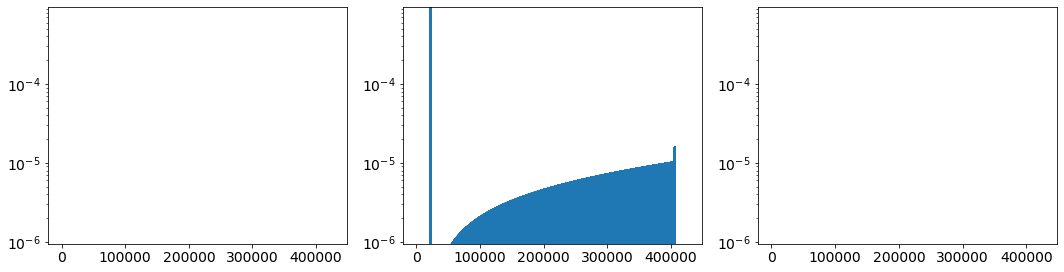

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
eps = 1e-3*np.max(abs(sm))
tind = 0

for a, s in zip(ax, [smx, smy, smz]):
    a.semilogy(np.abs(s))
    a.set_ylim(eps, np.max(abs(sm)))

    plt.tight_layout()

(0, 1000.0)

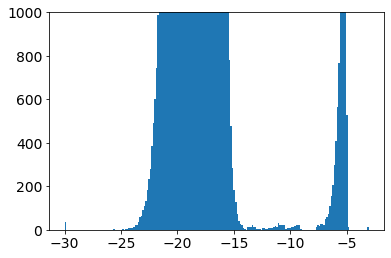

In [70]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(np.abs(smy + 1e-30)), bins = 200)
ax.set_ylim([0, 1e3])

In [71]:
smy = smy.reshape(mesh.vnEy, order="F")

In [72]:
from matplotlib import cm as cmap

0.0009429075943582119
2.357904355875754e-14
4.8589840672544414e-14
7.503198497730418e-14
8.167685373517647e-06


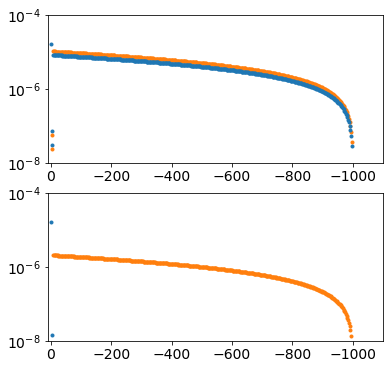

In [73]:
fig, ax = plt.subplots(2, 1, figsize = (6, 6))
theta_ind = 3
src_ind = 0
tind = 0

sm = compute_sm_error(survey.srcList[src_ind], tind=tind, key="approx_casing", primary_key="casing", separate=False)
smy = sm[mesh.vnE[0]:mesh.vnE[:2].sum()]
smy = smy.reshape(mesh.vnEy, order="F")

rinds = np.where((mesh.vectorNx >= model.casing_a*0.9) & (mesh.vectorNx <= model.casing_b))[0][[0, -1]] 
colors = cmap.viridis(np.linspace(0, 1, len(rinds)))

for val in range(rinds[0], rinds[1]+1):
    plotme = smy[val, 3, :]
    print(np.max(np.abs(plotme)))
    pos_inds = plotme > 0
    neg_inds = plotme < 0
    
    if np.any(pos_inds):
        ax[0].semilogy(mesh.vectorNz[pos_inds], plotme[pos_inds], '.', color='C0')
    if np.any(neg_inds):
        ax[0].semilogy(mesh.vectorNz[neg_inds], -plotme[neg_inds],'.', color='C1')

# ax[1].plot(mesh.vectorNz, np.abs(smy[rinds[0], 3, :]/smy[rinds[1], 3, :]), '.')
# ax[1].set_ylim([1.2, 1.3])

ax[1].semilogy(mesh.vectorNz, (smy[rinds[0]:rinds[1]+1, 3, :].sum(0)), '.', color='C0')
ax[1].semilogy(mesh.vectorNz, -(smy[rinds[0]:rinds[1]+1, 3, :].sum(0)), '.', color='C1')

for a in ax:
    a.set_xlim([10, -model.casing_l*1.1])
    a.set_ylim([1e-8, 1e-4])




In [74]:
mesh.vectorNx[rinds]

array([0.0375, 0.0475])

In [75]:
model.casing_a

0.04000000000000001

In [76]:
model.casing_b

0.05

In [77]:
mesh.vectorNx[:22]

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
       0.04  , 0.0425, 0.045 , 0.0475, 0.05  , 0.0525])

In [78]:
zinds = (mesh.vectorNz < -0.125) & (mesh.vectorNz > -model.casing_l)


In [79]:
nT = sim.time_mesh.nC
sm_surface = np.zeros((zinds.sum(), nT))
theta_ind = 3
src_ind = 1


sm_ti = compute_sm_error(survey.srcList[src_ind], tind=None, key="approx_casing", primary_key="casing", separate=False)
for ti in range(nT):
    sm_ti_y = sm_ti[mesh.vnE[0]:mesh.vnE[:2].sum(), ti].reshape(mesh.vnEy, order="F")
    sm_surface[:, ti] = sm_ti_y[rinds[0]:rinds[1]+1, theta_ind, zinds].sum(0) 
    

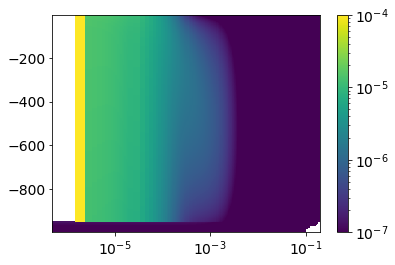

In [80]:
fig, ax = plt.subplots(1, 1)
clim = np.r_[1e-7, 1e-4]
plt.colorbar(
    ax.pcolormesh(sim.time_mesh.vectorCCx, mesh.vectorNz[zinds], -sm_surface, norm=LogNorm(vmin=clim.min(), vmax=clim.max())),
    ax=ax
)
ax.set_xscale('log')

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


(-9.0, -4.0)

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


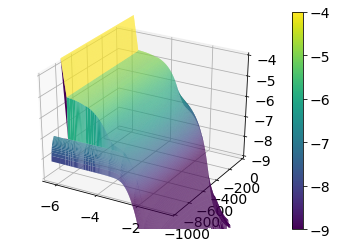

In [81]:
fig = plt.figure()
ax = fig.gca(projection='3d')

clim = np.r_[1e-9, 1e-4]
X, Y = np.meshgrid(np.log10(sim.time_mesh.vectorCCx), mesh.vectorNz[zinds])
plt.colorbar(
    ax.plot_surface(
        X, Y, np.log10(-sm_surface), 
        rstride=1, cstride=1, cmap="viridis", 
        edgecolor='none', 
        vmin=np.log10(clim.min()),
        vmax=np.log10(clim.max())
        #vmin=np.log10(clim.min()), vmax=np.log10(clim.max())), # , norm=LogNorm(vmin=clim.min(), vmax=clim.max())),

    ),
    ax=ax
)
ax.set_ylim(np.r_[-model.casing_l, 0.])
ax.set_zlim(np.log10(clim))
# ax.set_xscale('log')

In [82]:
n_theta = mesh.nCy
sm_theta = np.zeros((zinds.sum(), n_theta))
time_ind = 100

sm_ti = compute_sm_error(survey.srcList[0], tind=time_ind, key="approx_casing", primary_key="casing", separate=False)

for theta_ind in range(n_theta):
    sm_ti_y = sm_ti[mesh.vnE[0]:mesh.vnE[:2].sum()].reshape(mesh.vnEy, order="F")
    sm_theta[:, theta_ind] = sm_ti_y[rinds[0], theta_ind, zinds] + sm_ti_y[rinds[1], theta_ind, zinds] 
    

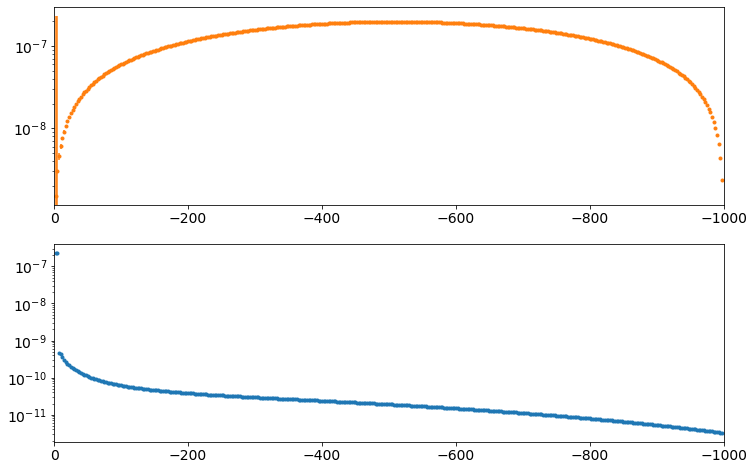

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

pos_vals = sm_theta.mean(1) > 0. 
neg_vals = sm_theta.mean(1) < 0.

if any(pos_vals):
    ax[0].errorbar(
        mesh.vectorNz[zinds][pos_vals], sm_theta.mean(1)[pos_vals], sm_theta.std(1)[pos_vals], 
        color='C0', fmt='.', ls=None
    )
if any(neg_vals):
    ax[0].errorbar(
        mesh.vectorNz[zinds][neg_vals], -sm_theta.mean(1)[neg_vals], sm_theta.std(1)[neg_vals], 
        color='C1', fmt='.', ls=None
    )


ax[0].set_yscale("log")

ax[1].semilogy(mesh.vectorNz[zinds], sm_theta.std(1), '.')
# ax[1].set_ylim(1e-7*np.r_[-0.10, 1])

for a in ax:
    a.set_xlim([0, -model.casing_l])

In [84]:

nT = sim.time_mesh.nC
n_theta = mesh.nCy

sm_theta_time = np.zeros((zinds.sum(), n_theta, nT))
src_ind = 1

for time_ind in range(nT):
    sm_ti = compute_sm_error(survey.srcList[src_ind], tind=time_ind, key="approx_casing", primary_key="casing", separate=False)

    for theta_ind in range(n_theta):
        sm_ti_y = sm_ti[mesh.vnE[0]:mesh.vnE[:2].sum()].reshape(mesh.vnEy, order="F")
        sm_theta_time[:, theta_ind, time_ind] = sm_ti_y[rinds[0], theta_ind, zinds] + sm_ti_y[rinds[1], theta_ind, zinds] 


In [85]:
from matplotlib import colors
from matplotlib import cm as cmap

In [86]:
sim.nT

187

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


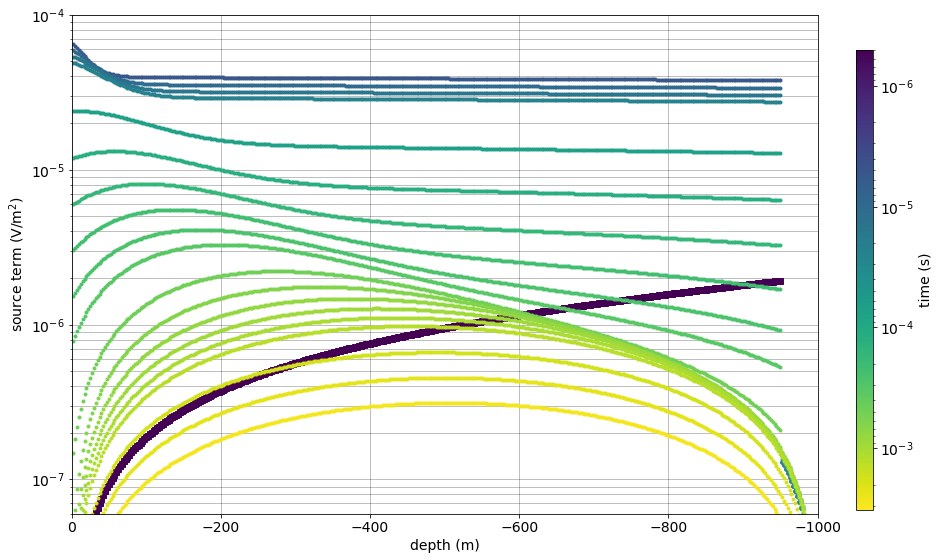

In [87]:
nT = 100

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.time_mesh.vectorCCx[0], vmax=sim.time_mesh.vectorCCx[nT])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])
# colors = cm.viridis(np.linspace(0, 1, nT))

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for time_ind in range(nT)[::int(nT/20)]:
    plotme = sm_theta_time[:, :, time_ind].mean(1)
    pos_vals = plotme > 0. 
    neg_vals = plotme < 0.
    
    color = scalar_map.to_rgba(sim.time_mesh.vectorCCx[time_ind])

    if any(pos_vals):
        ax.semilogy(
            mesh.vectorNz[zinds][pos_vals], plotme[pos_vals],
            color=color, marker='s', ls='None'
        )
    if any(neg_vals):
        ax.semilogy(
            mesh.vectorNz[zinds][neg_vals], -plotme[neg_vals], 
            color=color, marker='.', ls='None'
        )


ax.set_xlim([0, -model.casing_l])
ax.set_ylim([6e-8, 1e-4])
ax.grid(which="both", color="k", lw=0.5, alpha=0.5)
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('time (s)')
cb.ax.invert_yaxis()

ax.set_xlabel("depth (m)")
ax.set_ylabel("source term (V/m$^2$)")

plt.tight_layout()

In [88]:
from matplotlib.colors import Normalize

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10


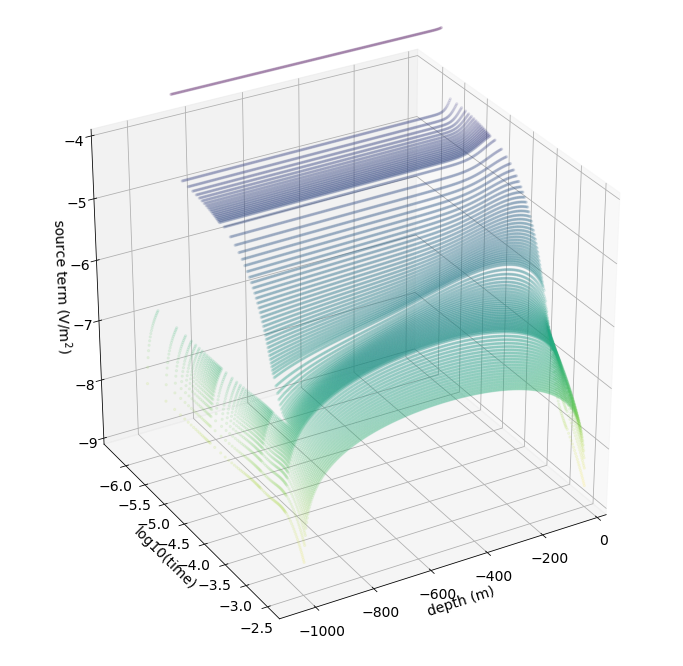

In [89]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

nT = 100 #sim.nT-1

cm = plt.get_cmap('viridis_r')
Z = sm_theta_time[:, :, 0:nT].mean(1)

c_norm = Normalize(vmin=np.log10(-Z[Z <0].max()), vmax=np.log10(-Z[Z <0].min()))
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

alpha = 0.1

for time_ind in range(nT):

    plotme = sm_theta_time[:, :, time_ind].mean(1)
    pos_vals = plotme > 0. 
    neg_vals = plotme < 0.

    time = sim.time_mesh.vectorCCx[time_ind]

#     if any(pos_vals):
#         ax.scatter(
#             mesh.vectorNz[zinds][pos_vals], np.log10(np.r_[time]), np.log10(plotme[pos_vals]),
#             color=color, marker='s', ls='None', alpha=alpha
#         )
    if any(neg_vals):
        
        zvals = np.log10(-plotme[neg_vals])
        cols = scalar_map.to_rgba(zvals)
        
        ax.scatter(
            mesh.vectorNz[zinds][neg_vals], np.log10(np.r_[time]), zvals, 
            color=cols, marker='.', ls='None', alpha=alpha
        )

zlim = np.r_[-9, -4]
xlim = np.r_[10, -model.casing_l*1.1]
ax.set_xlim(xlim)
ax.set_zlim(zlim)


ax.set_xlabel("depth (m)")
ax.set_ylabel("log10(time)")
ax.set_zlabel("source term (V/m$^2$)")

X = mesh.vectorNz[zinds]
Y = np.log10(sim.time_mesh.vectorCCx[0:nT])
Z = sm_theta_time[:, :, 0:nT].mean(1).T
neg_vals = Z < 0. 
Z = np.ma.array(np.log10(-Z), mask=~neg_vals)

X, Y = np.meshgrid(X, Y)

# cset = ax.contour(X, Y, Z, 20, zdir='z', offset=zlim.min(), cmap=cmap.viridis)
# cset = ax.contour(X, Y, Z, 20, zdir='x', offset=xlim.max(), cmap=cmap.viridis)
# cset = ax.contour(X, Y, Z, zdir='z', offset=zlim.min(), cmap=cmap.gray)
# cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.gray)
# cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.gray)

ax.view_init(30, 60)



In [90]:
Z

masked_array(
  data=[[-8.058976644886485, -7.783912435101121, -7.623441410423788, ...,
         --, --, --],
        [-8.058976638808167, -7.783912428675303, -7.623441403466438, ...,
         -3.1481122960629455, -3.145589957414036, -3.1422714877835007],
        [-8.058976602047288, -7.783912390161347, -7.623441362256433, ...,
         -4.218108330541894, -4.194229096497483, -4.169367889291126],
        ...,
        [-8.496650558776473, -8.22172247014677, -8.061399102328846, ...,
         -8.20141112893526, -8.37715557743887, -8.677615306462556],
        [-8.52764479516004, -8.252720340466906, -8.092400990365666, ...,
         -8.234150703678399, -8.409894936741312, -8.710353852416677],
        [-8.558667581601673, -8.283746683940466, -8.123431298788324, ...,
         -8.266738076607039, -8.442482060321584, -8.742940093490686]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fa

# create a TDEM source

In [91]:
import properties
from SimPEG.electromagnetics.time_domain.sources import BaseTDEMSrc, BaseWaveform

In [92]:
tdem.sources.BaseWaveform?

Init signature: tdem.sources.BaseWaveform(*args, **kwargs)
Docstring:     
**Required Properties:**

* **eps**: window of time within which the waveform is considered on, a float, Default: 1e-09
* **hasInitialFields**: Does the waveform have initial fields?, a boolean, Default: False
* **offTime**: off-time of the source, a float, Default: 0.0
File:           /global/u2/l/lheagy/git/simpeg/simpeg/SimPEG/electromagnetics/time_domain/sources.py
Type:           PropertyMetaclass
Subclasses:     StepOffWaveform, RampOffWaveform, RawWaveform, TriangularWaveform, VTEMWaveform, TrapezoidWaveform, QuarterSineRampOnWaveform


In [93]:
class RawVecSm(BaseTDEMSrc):
    
    _s_m = properties.Array("numpy aray of the source term", shape=('*', '*'))
    
    def __init__(self, receiver_list, waveform=None, s_m=None, **kwargs):
        super(BaseTDEMSrc, self).__init__(**kwargs)
        self.srcType="inductive"
        self._s_m = s_m
        self.waveform = BaseWaveform()
        self.waveform.hasInitialFields = False
        
    def s_m(self, simulation, time_index):
        return self._s_m[:, time_index]

In [94]:
source_list_discrepancy = []

for src in survey.source_list:
    source_list_discrepancy.append(
        RawVecSm([], s_m=compute_sm_error(src, key="approx_casing", primary_key="casing", separate=False))
    )

In [95]:
source_list_discrepancy

[<__main__.RawVecSm at 0x2aacd7af54e0>, <__main__.RawVecSm at 0x2aacdd9d6ef0>]

In [96]:
survey_discrepancy = tdem.Survey(source_list_discrepancy)
sim_discrepancy = tdem.Problem3D_j(
    mesh=mesh, survey=survey_discrepancy, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
    time_steps=timeSteps
)

In [97]:
if use_cluster is True: 
    cluster = dask_jobqueue.SLURMCluster(
        cores=1,
        processes=1, memory='120GB', 
        job_cpu=2,
        project="m3384",
        job_extra = ['--constraint=haswell', '--qos=debug',], 
        death_timeout=360,
    )

    print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=2
#SBATCH --mem=112G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug
JOB_ID=${SLURM_JOB_ID%;*}



/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.44:41067 --nthreads 1 --memory-limit 120.00GB --name dask-worker--${JOB_ID}-- --death-timeout 360



In [100]:
cluster.adapt(1)

In [101]:
client

Client Scheduler: tcp://128.55.224.44:46769 Dashboard: http://128.55.224.44:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
f_discrepancy = {}

key = "approx_casing"
value = physprops_dict[key]
time = datetime.datetime.now()
model = model_dict[key]
directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

model.save(f"{key}.json", directory)

f_discrepancy[key] = dask.delayed(run_simulation)(
    value.sigma, sim_discrepancy.serialize(), directory, key
)

# f_discrepancy[key] = run_simulation(
#     value.sigma, sim_discrepancy.serialize(), directory, key
# )
    
    

Saved 201983114/1000m_sigma1e-02/approx_casing.json


In [ ]:
fields_file_discrepancy = dask.compute(f_discrepancy)[0]